1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter

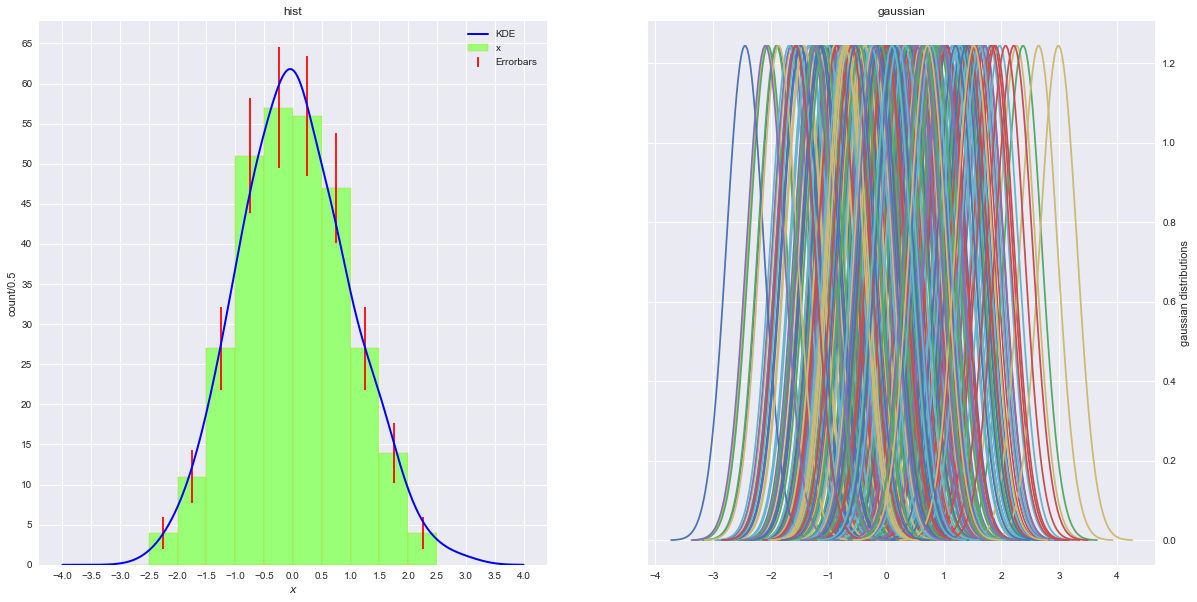

In [158]:
N=300
mean, std=0,1

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
                               
x=np.random.normal(mean,std,N)

larg=int(std/(2*0.5))*0.5

#faccio l'istogramma

y=ax1.hist(x, bins=(np.arange(int(x.min())-1,int(x.max())+1,larg)),label='x', color='#99ff77', edgecolor='y')
ax1.set_xlabel('$x$')
ax1.set_ylabel('count/'+str(larg))
ax1.set_title('hist')
ax1.grid(True)
ax1.set_axisbelow(True)  #griglia in background

ax1.yaxis.set_major_locator(MultipleLocator(int(5*std)))
ax1.xaxis.set_major_locator(MultipleLocator(larg))

#faccio le barre d'errore

bincenters = 0.5*(y[1][1:]+y[1][:-1])
#qui sto sommando elementwise tutti gli elementi dell'array y tranne il primo più tutti gli elementi dell'array y tranne l'ultimo
meanStd     = np.sqrt(y[0])
#ax1.bar(bincenters, y[0], width=larg, color='#99ff77', label='x', yerr=menStd, ecolor='#ff0000', edgecolor='y')
#quest'ultimo comando è quello che effettivamente fa il plot sia di istogramma che di barre
ax1.errorbar(bincenters, y[0],yerr=meanStd, fmt = 'none', label = "Errorbars", ecolor='#ff0000')
#quest'ultimo fa solo le barre invece ma riesce a mettere la legenda delle errorbar

#faccio le gaussiane

stdx=1.06*x.size**(-1/5)*x.std()

ax2.set_title('gaussian')
ax2.set_ylabel('gaussian distributions')
ax2.grid(True)
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()

for c in x:
    interval=np.linspace(c-4*stdx,c+4*stdx, 100)
    ax2.plot(interval, sp.stats.norm.pdf(interval,loc=c,scale=stdx))
    
#faccio la somma delle gaussiane, ho bisogno di creare un'array per fare il plot altrimenti non posso fare la linea continua

xinter=np.linspace(int(x.min())-2,int(x.max())+2, N)

v=np.zeros(len(x))
for i in range(len(v)):
    v[i]=larg*np.sum(sp.stats.norm.pdf(x,loc=xinter[i],scale=stdx))

ax1.plot(xinter,v,'b-', lw=2, label='KDE')
ax1.legend(markerscale=2)

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

In [ ]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')


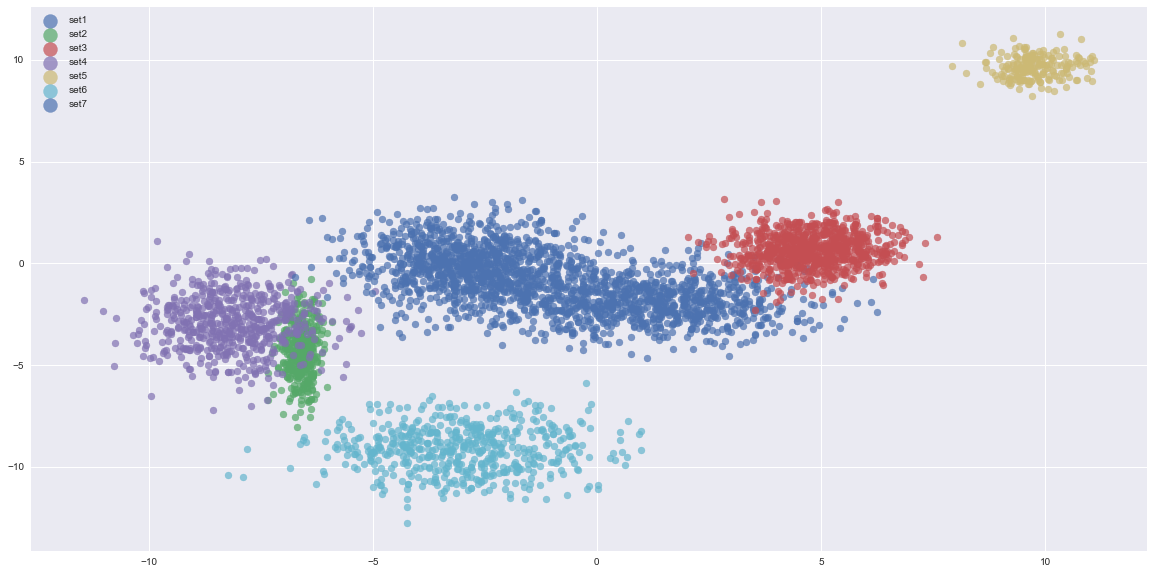

In [164]:
n=7
m=10
std=2
l=100
h=1000

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))


def generatore(N):

    for i in range(N):
        g=np.random.randint(l,h)
        
        m1=np.random.uniform(-m,m)
        m2=np.random.uniform(-m,m)
        
        std1=np.random.uniform(-std,std)
        std2=np.random.uniform(-std,std)
        
        x = np.random.normal(m1,abs(std1),g)
        y = np.random.normal(m2,abs(std2),g)

        ax.scatter(x,y,alpha=0.7,label='set'+str(i+1))
        

generatore(n)
ax.grid(True)
ax.legend(markerscale=2)

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should you the `np.load()` function to load the file as a numpy array and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [6]:
import pandas as pd
data= pd.DataFrame(np.load('/Users/marco/Desktop/laboratorio fisica computazionale/data/residuals_261.npy').item())
#item serve per evitare array 0 dimensionali


C:\Users\marco\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\marco\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


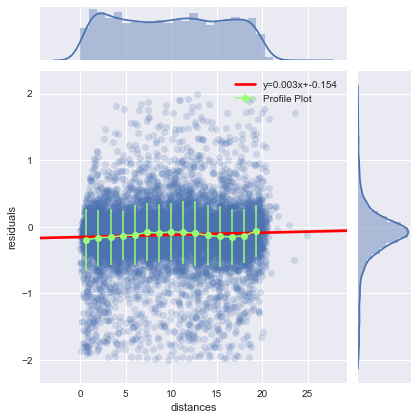

In [156]:
#eliminare dati che non vogliamo

data=data[abs(data['residuals'])<2]

#calcolare coefficienti retta

s=sp.stats.linregress(data['distances'],data['residuals'])
slope=s[0]
intercept=s[1]

#jointplot

sns.set()
ax = sns.jointplot("distances", "residuals", data=data, kind="reg",scatter_kws={'alpha':0.2},line_kws={'label':"y={0:.3f}x+{1:.3f}".format(slope,intercept),'color':'r'})

#riempire array x

nbin=15
his , b= np.histogram(data['distances'],nbin,range=(0,20))
x=  0.5*(b[1:] + b[:-1])

#riempire arrays y e erry

y=np.array([data.loc[(data['distances'] >=b[i]) & (data['distances'] <=b[i+1])]['residuals'].mean() for i in range(nbin)])
erry=np.array([data.loc[(data['distances'] >b[i]) & (data['distances'] <b[i+1])]['residuals'].std() for i in range(nbin)])

#plottare tutto

plt.errorbar(x,y,yerr=erry, label='Profile Plot',linewidth=1.5,color='#99ff77',marker='o')
ax.ax_joint.legend()